# Image Classification:

In this project, we will explore K Neighbors and Support Vector Machine classification algorithms to classify images.

### Exploring the Dataset: 

In this project, we will use the [house numbers](http://ufldl.stanford.edu/housenumbers/) dataset. This set is obtained from **Google Street View** photos of house numbers. There are more than 30,000 images and 13,000 images in training and testing folders respectively. Each image presents a house number consisting of a few digits. In both training and testing folders, metadata (specifically named digitStruct_training.mat and digitStruct_testing.mat) pertaining to the rectangular boxes that bound each digit in the images are included. Each element in digitStruct files has the following fields: name which is a string containing the filename of the corresponding image, 'bbox' which is a struct array that contains the position, size and label of each digit bounding box in the image. If the digit is 0, it's label value is represented by 10.    

Unfortunately, because of computational limitations, we will train and test our models using only a few thousand images.   

### Project Outline:

These are the steps we followed in this project:

#### Preparation of Features and Labels:

- Loaded images and displayed a few of them
- For both training and test sets, read the coordinations of each bounding box for each digit from digitStruct.mat file and chose an image and displayed boxes for each digit in the image for illustration purposes
- Created cut-out images of digits using coordinations obtained in the previous step
- Preprocessed these cut-out digit images by resizing, normalizing and flattening 
    to form features of the train and test sets
- Obtained target labels from digitStruct files for each corresponding digit 
    for train and test sets

#### KNeighbors:
 
- Applied KNeighbors algorithm with k values ranging from 3 to 17 in odd numbers 
    and plotted the accuracy to see which k value produces the optimal result
- Did more hyperparameter tuning by tweaking other parameters of the algorithm to see if we could obtain an even better accuracy (65%)
- Fed the algorithm with a few unseen images to determine the accuracy of it predicting the correct digits (71%)

#### Support Vector Machine (SVM):

- Application of SVM produced very poor accuracy (28%).
- To reduce distractions and increase sharpness, digit cut-outs were turned into binary images using Otsu's threshold and masking methods
- Above process increased accuracy from 28% to 66%
- Fed the algorithm with the same unseen images as in KNN, achieved 71% accuracy


In [1]:
#import necessary libraries
import os
from skimage import io
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import h5py
import matplotlib.patches as mpatches
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from skimage.filters import threshold_otsu
from skimage.color import rgb2gray
from skimage.transform import resize
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import  StandardScaler

In [2]:

#Load images from a folder:

def load_image(dir_name, start_number, end_number):
    '''
        
        This function takes in a directory name, a start number 
        and an end number. Start number is the number of the first image to load 
        (i.e. 5000.png) and end number is the last image's number (i.e. 5500.png).
        This function assumes all images' file names are integers and the extension 
        of the files is '.png'.
        
        It returns all images between the given numbers (including the last one) 
        as a list and the argument 'start_number', which will be used to display 
        the titles of the images.
    
    '''
    files = os.listdir(dir_name)
    images = []
    for i in range(start_number, end_number+1):
        images.append(io.imread(dir_name+'/{}.png'.format(i)))
    func_locals = locals()
    return images, func_locals['start_number']


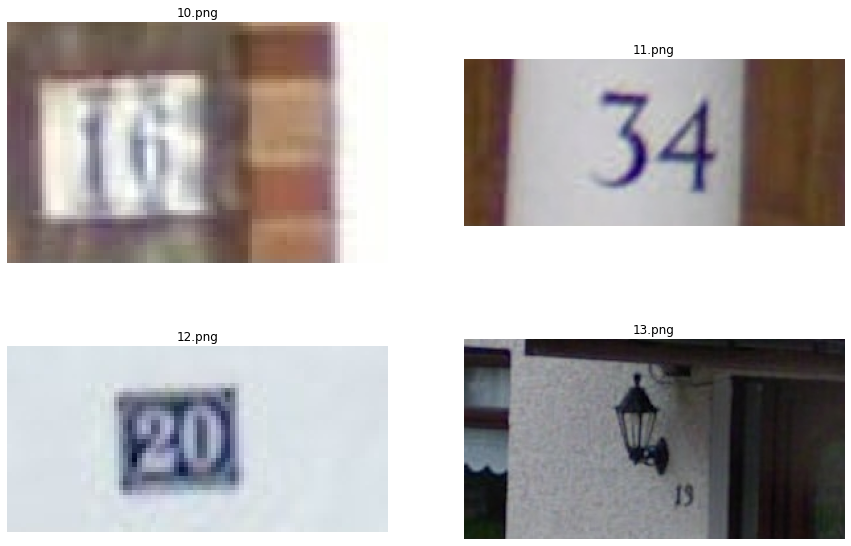

In [3]:
#Let's load 4 images to see if the function works.
#Load and display the images from 10.png to 13.png:

list_of_images, start = load_image('C:/Users/h/Desktop/test.tar/test', 10, 13)

#Display the images with appropriate titles:
fig, ax = plt.subplots(2,2, figsize=(15,10))
plt.axis('off')
ax=ax.ravel()
for i in range(len(list_of_images)):
    ax[i].imshow(list_of_images[i])
    ax[i].axis('off')
    ax[i].set_title(f'{start+i}.png')

We need to read the coordinates and labels of the digits' bounding boxes. The following code reads them from the provided metadata. Please note the code in this cell only is taken from [here](https://stackoverflow.com/questions/41176258/h5py-access-data-in-datasets-in-svhn).

In [4]:
#Please note the code in this cell is taken from:
#https://stackoverflow.com/questions/41176258/h5py-access-data-in-datasets-in-svhn
#Creating the metadata for the boxes 
#surrounding the numbers for the training set:

f = h5py.File('digitStruct_train.mat')

metadata= {}
metadata['height'] = []
metadata['label'] = []
metadata['left'] = []
metadata['top'] = []
metadata['width'] = []

def print_attrs(name, obj):
    vals = []
    if obj.shape[0] == 1:
        vals.append(int(obj[0][0]))
    else:
        for k in range(obj.shape[0]):
            vals.append(int(f[obj[k][0]][0][0]))
    metadata[name].append(vals)

for item in f['/digitStruct/bbox']:
    #print(f[item[0]])
    f[item[0]].visititems(print_attrs)



<ipython-input-4-bd7b16134e32>:6: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File('digitStruct_train.mat')


We obtained the data for the bounding boxes. Let's draw the boxes of the digits on an image to see if the coordinates are right. 

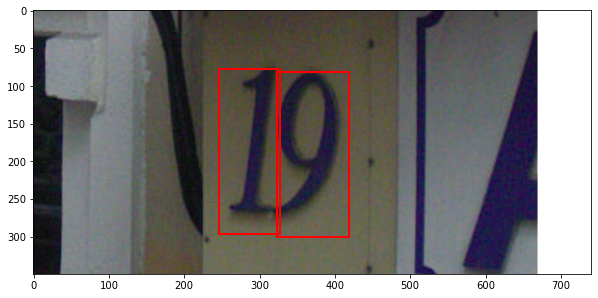

In [5]:
#Load an image
image, start = load_image('C:/Users/h/Desktop/train.tar/train', 1, 1)
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image[0])
#Draw the boxes for the digits using patches.
for j in range(len(metadata['label'][0])):
    mint, minc, maxt, maxc = metadata['left'][0][j], metadata['top'][0][j],\
        metadata['width'][0][j], metadata['height'][0][j]
    rect =mpatches.Rectangle((mint, minc),maxt, maxc, fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)


We will follow the same procedure for the test set. We will read box coordinate data from 'digitStruct_test.mat' file.

In [6]:
#Creating the metadata for the boxes 
#drawn around the numbers for the test set:

f_test = h5py.File('digitStruct_test.mat')

metadata_test= {}
metadata_test['height'] = []
metadata_test['label'] = []
metadata_test['left'] = []
metadata_test['top'] = []
metadata_test['width'] = []

def print_attrs_test(name, obj):
    vals = []
    if obj.shape[0] == 1:
        vals.append(int(obj[0][0]))
    else:
        for k in range(obj.shape[0]):
            vals.append(int(f_test[obj[k][0]][0][0]))
    metadata_test[name].append(vals)

for item in f_test['/digitStruct/bbox']:
    #print(f[item[0]])
    f_test[item[0]].visititems(print_attrs_test)



<ipython-input-6-801361bc860a>:4: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f_test = h5py.File('digitStruct_test.mat')


Let's draw the boxes of the digits on an image.

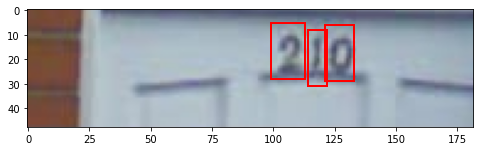

In [7]:
#Load an image from the test set and draw boxes around the digits:
image, start = load_image('C:/Users/h/Desktop/test.tar/test', 1, 2)
fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(image[1])

for j in range(len(metadata_test['label'][1])):
        mint, minc, maxt, maxc = metadata_test['left'][1][j], metadata_test['top'][1][j],\
        metadata_test['width'][1][j], metadata_test['height'][1][j]
        rect =mpatches.Rectangle((mint, minc),maxt, maxc, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

When we take a look at the images above, we see some of them have a very washed-out appearance whereas some have more definite contrast. This will reflect on the range of the pixel values. The algorithm may put more weight on the larger ranged images or vice versa and that would introduce bias. To prevent this, we need to apply feature scaling, so all digit images play equal roles in training the algorithm.
The following function will scale (normalize) train and test sets by applying a StandardScaler(). A StandardScaler() changes the values of a feature column proportionally, so that the column's mean value and variance become 0 and 1 respectively.

In [8]:
def normalize(train, test):
    '''
        This function takes in a train and test set.
        It applies normalization to each channel of each image in both sets.
    '''
    ss = StandardScaler()
    for image in train:
        for channel in range(image.shape[2]):
            image[:,:,channel] = ss.fit_transform(image[:,:,channel])
    for image in test:
        for channel in range(image.shape[2]):
            image[:,:,channel] = ss.transform(image[:,:,channel])
    

The house numbers on the images consist of one or more digits and we are given the label value for each digit in the metadata. That means we need to extract digits from those images and save their data in a list, so that each label value will correspond to an entry in that list.
To extract the digits from the images, we will use the coordinates of the bounding boxes.
The following function will go through the provided train and test sets, and for each image in those sets, it will create a cut-out image of each digit and save it into an appropriate list. In the end, we will have two lists train_x and test_x, which will contain the cut-outs of digits  in the train and test sets respectively. 
As the function goes through the train and test sets, it will also extract the corresponding label value for each digit from the metadata and add it to train_y and test_y lists.
Please note, unfortunately, the bounding box height or width was zero for some digits in the images, so the function was written in a way to omit those cases.

In [9]:
#Creating digit cut-outs from the images 
#and capturing corresponding labels by using metadata:
def create_x_y(training_list,training_start, testing_list, testing_start):
    '''
        This function captures digit cut-outs from the images provided in train and test sets.
        It also saves corresponding label values for those digits.
        'training_start' and 'testing_start' inputs need to be provided so that the function can find 
        the corresponding metadata for the provided images.
        If for any digit, the bounding box's height or width is zero, that digit is omitted.
        The function saves digit cut-out images in train_x, and test_x lists and corresponding label
        values in train_y and test_y lists and finally returns these four lists.
        '''
    train_x = []
    train_y = []
    for i in range(len(training_list)):
        image = training_list[i]
        for j in range(len(metadata['label'][i+training_start-1])):
            cut_out = image[metadata['top'][i+training_start-1][j]:metadata['top'][i+training_start-1][j]+metadata['height'][i+training_start-1][j],\
                                metadata['left'][i+training_start-1][j]:metadata['left'][i+training_start-1][j]+metadata['width'][i+training_start-1][j],:] 
            if cut_out.shape[0] == 0 or cut_out.shape[1] == 0:
                continue
            else:
                train_x.append(cut_out)
                train_y.append(metadata['label'][i+training_start-1][j])
    test_x = []
    test_y = []
    for i in range(len(testing_list)):
        image = testing_list[i]
        for j in range(len(metadata_test['label'][i+testing_start-1])):
            cut_out = image[metadata_test['top'][i+testing_start-1][j]:metadata_test['top'][i+testing_start-1][j]+metadata_test['height'][i+testing_start-1][j],\
                                metadata_test['left'][i+testing_start-1][j]:metadata_test['left'][i+testing_start-1][j]+metadata_test['width'][i+testing_start-1][j],:] 
        
            if cut_out.shape[0] == 0 or cut_out.shape[1] == 0:
                continue
            else:
                test_x.append(cut_out)
                test_y.append(metadata_test['label'][i+testing_start-1][j])
    return train_x, train_y, test_x, test_y


Now that we have a way of obtaining cut-outs of digits, we need to develop a way to preprocess them before using them in an algorithm as they are all in different sizes, and may have different ranges of intensity values, which may skew algorithm's accuracy as mentioned before. Also, each image has three channels (three arrays) and we need to flatten them, so that each image is represented by one array.
The following funtion takes in train and test sets and applies all the aforementioned changes to the images in those sets and returns processed train and test sets. Specifically, the size of all images in those sets are adjusted to (16, 16, 3), boths sets are normalized, and each image's dimension is reduced to 1D array. 

In [10]:
def resize_norm_flatten(train_x, test_x):
    '''
        This function takes in train and test sets. 
        Each image in these sets is resized to (16, 16, 3), 
        both sets are normalized, and finally for each image 
        channel arrays are appended one after another so
        the image is represented by only one array.
        The function saves processed image data in lists and converts 
        them into numpy arrays named train_x_arr and 
        test_x_arr and returns these arrays.
        
    '''
    train_x_resized = []
    test_x_resized = []
    for i in train_x:
        train_x_resized.append(resize(i[:,:,:], (16, 16, 3)))
    for i in test_x:
        test_x_resized.append(resize(i[:,:,:], (16, 16, 3)))
    train_x_resized = np.array(train_x_resized)
    test_x_resized = np.array(test_x_resized)
    normalize(train_x_resized, test_x_resized)
    train_x_flat = []
    test_x_flat = []
    for i in range(len(train_x_resized)):
        train_x_flat.append(train_x_resized[i].flatten())
    for i in range(len(test_x_resized)):
        test_x_flat.append(test_x_resized[i].flatten())
    
    train_x_arr = np.array(train_x_flat)
    test_x_arr = np.array(test_x_flat)
    return train_x_arr, test_x_arr

At this point, we are ready to create our train and test arrays to feed our algorithm with from a given set of images. Let's go one step further and present features and labels in a dataframe. This step is not necessary, but it will provide a nice presentation of all features and labels in one table. The following function takes in features and labels of train and test sets and returns train and test dataframes.

In [11]:
def x_y_dataframes(train_x, train_y, test_x, test_y):
    '''
        This function takes in train and test features and labels
        and returns train and test dataframes.
    
    '''
    train_x_arr = np.array(train_x)
    test_x_arr = np.array(test_x)
    train=pd.DataFrame(train_x_arr)
    train['Target'] = train_y
    test = pd.DataFrame(test_x_arr)
    test['Target'] = test_y 
    return train, test

Finally, we are set to produce train and test features and labels that are algorithm ready. 
In the following, we will use the necessary functions to 
- load the images,
- extract cut-outs of the digits in those images along with their corresponding label values,
- resize, normalize and flatten digit cut-outs,
- create dataframes for train and test sets,
- select features of train set and assign it to train_x,
- select labels of train set and assign it to train_y,
- select features of test set and assign it to test_x,
- select labels of test set and assign it to test_y.

In [12]:
#load the images
training_list,training_start = load_image('C:/Users/h/Desktop/train.tar/train', 1, 3000)
testing_list,testing_start = load_image('C:/Users/h/Desktop/test.tar/test',1, 1000)
#extract cut-outs of the digits in those images along with their corresponding label values
train_x_cut_out, train_y, test_x_cut_out, test_y = create_x_y(training_list,training_start, testing_list, testing_start)
#resize, normalize and flatten digit cut-outs
train_x_normed, test_x_normed = resize_norm_flatten(train_x_cut_out, test_x_cut_out)
#create dataframes for train and test sets
train_data, test_data = x_y_dataframes(train_x_normed,train_y, test_x_normed, test_y)
#select features of train set and assign it to train_x
train_x=train_data.iloc[:,:-1]
#select labels of train set and assign it to train_y
train_y=train_data.iloc[:,-1]
#select features of test set and assign it to test_x
test_x=test_data.iloc[:,:-1]
#select labels of test set and assign it to test_y
test_y=test_data.iloc[:,-1]


In [13]:
train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,Target
0,-1.903551,-1.544534,-1.568251,-1.845708,-1.508277,-1.815568,-1.854487,-1.673768,-1.915676,-1.275757,...,1.132903,1.383082,1.420381,1.209686,1.468709,1.521597,1.292658,1.925495,1.330627,1
1,-0.392150,-0.218664,-1.979654,0.475593,0.405734,-0.876508,0.700727,0.620197,-0.300131,0.710758,...,1.190009,1.357066,1.346536,1.040185,1.789114,1.072222,1.085448,1.804649,1.225765,9
2,-1.507090,-1.689837,-1.864549,-1.690265,-1.923359,-2.232245,-1.829054,-2.096952,-2.583954,-1.858861,...,-1.553272,-1.364504,-0.331849,-1.171407,-0.898402,1.380113,-1.046251,-0.139586,1.666758,2
3,-2.545194,-3.237610,-2.851920,-1.827265,-2.286120,-0.668322,-1.163772,-1.087607,0.192567,-1.438932,...,-1.487122,-1.798848,-1.678467,-1.083340,-1.380034,0.582358,-0.217759,-0.518767,1.531829,3
4,-0.221750,0.048073,-0.667597,-0.221750,0.048073,-0.667597,-0.129202,0.073682,-0.735411,0.153447,...,0.961936,0.941227,0.915922,0.769972,0.836198,0.793803,0.769972,0.836198,0.793803,2


## Image Classification with K Nearest Neighbors Algorithm:

K Nearest Neighbors (KNN) is a supervised learning algorithm that can be used for both classification and regression problems.

It works based on the assumption that similar data points should be in close proximity. For each unlabeled data point, it looks at the 'k' closest labeled data points (neighbors) and gets their votes. The unlabeled data point is assigned to the class that the majority of its k numbered neighbors belong to. Here, 'k' is a user determined parameter of the algorithm. If none is given, 5 is the default value. To avoid ties in voting, only odd numbers are considered for k.

In the following, we will train our KNN model with different k values ranging from 3 to 17 in odd numbers to see which one provides a better accuracy for training and testing. 

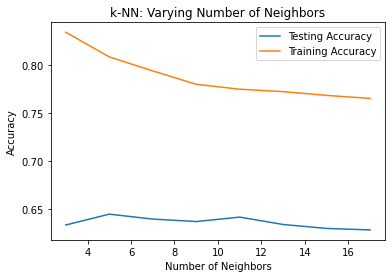

In [14]:
#Create an array of k values ranging from 3 to 17 in odd numbers
neighbors = np.arange(3,19,2)
#Create two empty arrays to hold the accuracy values for training and testing 
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))
#Train and test the model with various k values, save the accuracy scores:
for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_x, train_y)
    train_accuracy[i] = knn.score(train_x, train_y)
    test_accuracy[i] = knn.score(test_x, test_y)
#Plot training and testing accuracy scores:
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

In [15]:
print(f'The highest testing accuracy is {max(np.round(test_accuracy,3))}.')

The highest testing accuracy is 0.645.


From the plot, we see that when k is 5, testing accuracy is the highest (0.645) and training accuracy only goes down after that point. So choosing 5 neighbors seems like a good move.
Let's see if we can obtain an even better accuracy by tweaking other parameters. We will do a grid search to explore the options. We will not specify a n_neighbors (k) value, because we decided 5 is the best choice and it is also the default value.

In [16]:
params = {
                        'weights' : ['uniform','distance'],
                        'metric' : ['euclidean', 'chebyshev']
                        }
gs = GridSearchCV(
                            KNeighborsClassifier(),
                            params,
                            verbose = 1,
                            cv=3,
                            n_jobs=-1
)
knn = gs.fit(train_x, train_y)
print(f'The best training score is {np.round(knn.best_score_,3)}')
print(f'The best parameters are {knn.best_params_}')

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.1min finished


The best training score is 0.709
The best parameters are {'metric': 'euclidean', 'weights': 'distance'}


In [17]:
print(f'The testing accuracy with the best parameters is {np.round(knn.score(test_x, test_y),3)*100}%.')

The testing accuracy with the best parameters is 65.2%.


So, we obtained a slightly better accuracy. Let's see if the algorithm will be able to predict the digits for several unseen images.
We need to go over the same process to get the images suitable for the algorithm. Let's load them first:

The images are: 


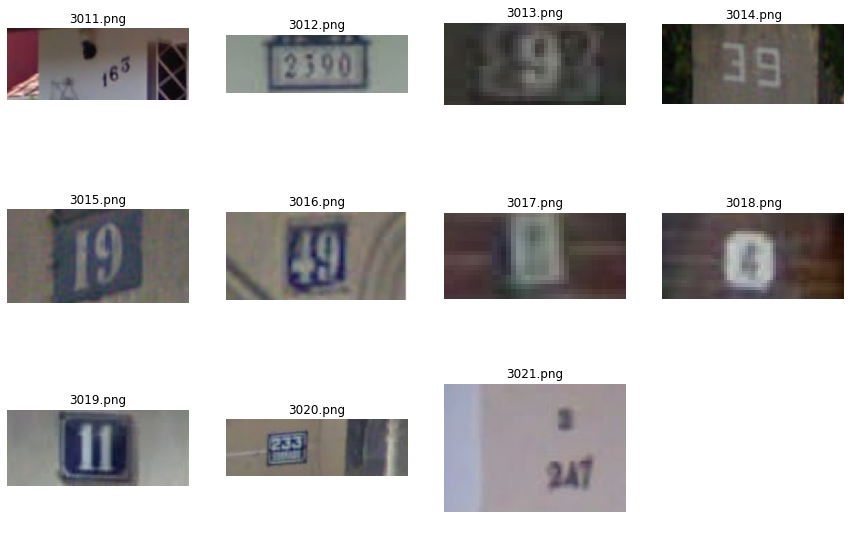

In [18]:
images,start = load_image('C:/Users/h/Desktop/train.tar/train', 3011, 3021)
print('The images are: ')
fig, ax = plt.subplots(3,4, figsize=(15,10))
plt.axis('off')
ax=ax.ravel()
for i in range(len(images)):
    ax[i].imshow(images[i])
    ax[i].axis('off')
    ax[i].set_title(f'{start+i}.png')


Let's extract the digit cut-outs and label values from the metadata:

In [19]:
x_cutout = []
y = []
for i in range(len(images)):
    image = images[i]
    for j in range(len(metadata['label'][i+start-1])):
            cut_out = image[metadata['top'][i+start-1][j]:metadata['top'][i+start-1][j]+metadata['height'][i+start-1][j],\
                                metadata['left'][i+start-1][j]:metadata['left'][i+start-1][j]+metadata['width'][i+start-1][j],:] 
            if cut_out.shape[0] == 0 or cut_out.shape[1] == 0:
                continue
            else:
                x_cutout.append(cut_out)
                y.append(metadata['label'][i+start-1][j])
print(f'There are {len(x_cutout)} digits in the images.')
print(f'The digits in the images are: {y}')

There are 24 digits in the images.
The digits in the images are: [1, 6, 3, 2, 3, 9, 10, 9, 3, 9, 1, 9, 4, 9, 2, 4, 1, 1, 2, 3, 3, 2, 4, 7]


We extracted 24 digit cut-outs. Let's display them:

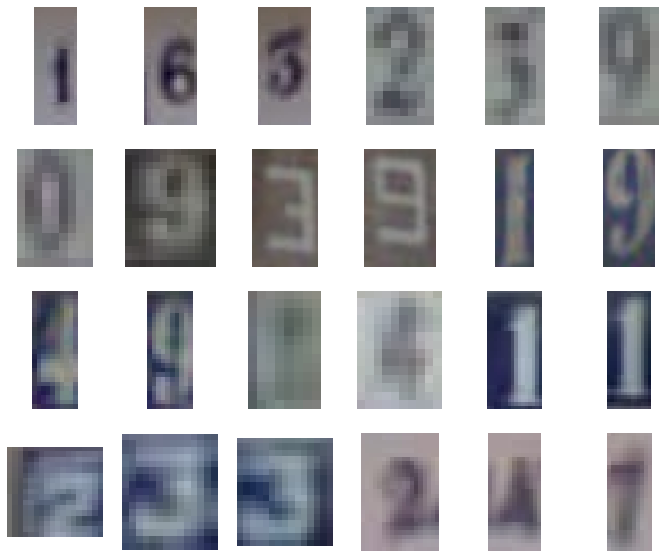

In [20]:
fig, ax = plt.subplots(4,6, figsize=(12,10))
ax=ax.ravel()
for i in range(len(x_cutout)):
    ax[i].imshow(x_cutout[i])
    ax[i].axis('off')

Some of the digits are so washed out, even human eye can't make out what they are. Let's see how our model will do.

Let's resize and normalize the digit cut-outs:

In [21]:
x_resized = []
#Resize digit cutouts
for i in x_cutout:
        x_resized.append(resize(i[:,:,:], (16, 16, 3)))
#Normalize the array
ss = StandardScaler()
for image in x_resized:
    for channel in range(image.shape[2]):
        image[:,:,channel] = ss.fit_transform(image[:,:,channel])
print(f'The mean of the input array is {np.round(np.mean(x_resized),2)}, variance is {np.var(x_resized)}')    

The mean of the input array is -0.0, variance is 1.0


The input array's shape is still not suitable for the algorithm. We need to reduce each image's dimension from 3D to 1D:

In [22]:
x_resized = np.array(x_resized)
print(f'The shape of the resized, normalized input array is {x_resized.shape}.')
x_flat = []
for i in range(len(x_resized)):
        x_flat.append(x_resized[i].flatten())
x = np.array(x_flat) 
print(f'The shape of the flattened input array is {x.shape}.')

The shape of the resized, normalized input array is (24, 16, 16, 3).
The shape of the flattened input array is (24, 768).


Finally, our input array (x) is ready for our KNN algorithm. Let's see how our model will fare: 

In [23]:
predicted = knn.predict(x)
print(f'Predicted digits are {predicted}')
y = np.array(y)
print(f'Actual digits are      {y}')
print(f'The model predicted {np.round(accuracy_score(predicted, y)*100,2)}% of the cases correctly.')

Predicted digits are [ 1  4  1  2  1  9 10  9  3  9  1  9  4  9  1  4  1  1  1  3  3  1  4  1]
Actual digits are      [ 1  6  3  2  3  9 10  9  3  9  1  9  4  9  2  4  1  1  2  3  3  2  4  7]
The model predicted 70.83% of the cases correctly.


So, for this particular set of images our model's accuracy of 71% exceeded our expectation of accuracy which was around 65%. 

## Image Classification with Support Vector Machine (SVM):

Our KNN model did fairly well in predicting the numbers considering how some of the digits in the images are barely distinguishable.
Another classification algorithm we can use is Support Vector Machine (SVM). The way this algorithm works is, it creates a hyperplane that distinctly classifies the data points. The goal is to choose a hyperplane that maintains the maximum distance from the data points in either class, so the algorithm can classify a future data point with more precision. 
Let's try Support Vector Machine (SVC) algorithm on our training data. We need to do some hyper-parameter tuning first:

In [24]:
param_grid={'C':[0.1,1,10],'gamma':[0.001,0.1,1]}
svc=svm.SVC(probability=True, kernel='poly')
model=GridSearchCV(svc,param_grid)
model.fit(train_x,train_y)

GridSearchCV(estimator=SVC(kernel='poly', probability=True),
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.001, 0.1, 1]})

In [25]:
print(f'The best parameters for this model are {model.best_params_}')

The best parameters for this model are {'C': 10, 'gamma': 0.001}


Let's see how our model will do with these parameters:

In [26]:
y_pred=model.predict(test_x)
print(f"The model is {np.round(accuracy_score(y_pred,test_y),4)*100}% accurate.")

The model is 27.71% accurate.


The model did very poorly with this set. Let's try another approach. As we mentioned before, some images are extremely blurry. This would decrease the algorithm's accuracy. Let's process each digit cut-out image to make them less blurry. The process works as follows:
- After resizing the image to (32, 32, 3), convert it to grayscale
- Determine the threshold (Otsu) value of the image
- Turn the image to binary image using this threshold

The following function employs this process.

In [27]:
def process_image(image):
    '''
        This function takes in an image, resizes it to (32, 32, 3) and
        turns it to grayscale. After finding the image's threshold value (Otsu),
        it creates a binary version of the image and returns this binary image.
        
        '''
    image = resize(image[:,:,:], (32,32,3))
    image =rgb2gray(image)    
    thresh = threshold_otsu(image)
    mask = image < thresh
    binary = np.zeros(image.shape)
    binary[mask]=1
    return binary

Let's try this function on a digit cut-out:

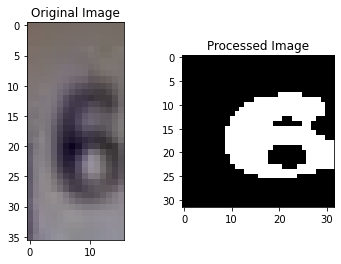

In [28]:
plt.subplot(1,2,1)
plt.imshow(x_cutout[1])
plt.title('Original Image')
plt.subplot(1,2,2)
plt.imshow(process_image(x_cutout[1]), cmap=plt.cm.gray)
plt.title('Processed Image')
plt.show()

The processed image is obviously less blurry and includes less distractions. Hopefully, these improvements on the images will help with the algorithm's accuracy. Let's process each digit cut-out image in the train and test sets.

In [29]:
training_list,training_start = load_image('C:/Users/h/Desktop/train.tar/train', 1, 3000)
testing_list,testing_start = load_image('C:/Users/h/Desktop/test.tar/test', 1, 1000)
train_x_cut_out, train_y, test_x_cut_out, test_y = create_x_y(training_list,training_start, testing_list, testing_start)
processed_train_x = []
processed_test_x = []
for i in train_x_cut_out:
    processed_train_x.append(process_image(i).flatten())
for i in test_x_cut_out:
    processed_test_x.append(process_image(i).flatten())
train = pd.DataFrame(processed_train_x)
train['Target'] = train_y
test = pd.DataFrame(processed_test_x)
test['Target'] = test_y
train_x = train.iloc[:, :-1]
train_y = train.iloc[:,-1]
test_x = test.iloc[:, :-1]
test_y = test.iloc[:,-1]

In [30]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,Target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


Let's train the algorithm one more time but this time with processed images:

In [31]:
svc=svm.SVC(C=10, gamma=0.001, kernel='poly', probability=True)
svc.fit(train_x,train_y)
y_pred=svc.predict(test_x)
print(f"The model is {np.round(accuracy_score(y_pred,test_y),4)*100}% accurate")

The model is 65.83% accurate


We increased the accuracy from 28% to 66% just by processing images.
Let's see how the algorithm will do with unseen images. These are the same 11 images we used on the KNN algorithm. The digit cut-outs extracted from these images were saved in x_cutout. We will process them and see if our algorithm can actually predict what they are. 

In [32]:
#create input array by processing and flattening unseen digit cut-outs.
processed_x = []
for i in x_cutout:
    processed_x.append(process_image(i).flatten())

In [33]:
predicted = svc.predict(processed_x)
print(f'Predicted digits are {predicted}')
y = np.array(y)
print(f'Actual digits are      {y}')
print(f'The model predicted {np.round(accuracy_score(predicted, y)*100,2)}% of the cases correctly.')


Predicted digits are [ 1  1  1  2  1  9 10  9  3  5  1  9  4  9  2  4  1  1  1  3  3  1  4  1]
Actual digits are      [ 1  6  3  2  3  9 10  9  3  9  1  9  4  9  2  4  1  1  2  3  3  2  4  7]
The model predicted 70.83% of the cases correctly.


The SVM did pretty well with this set of images with almost 71% accuracy. 